## GO-PCA Demo "`DMAP`"

```
Author: Florian Wagner
Email: florian.wagner@duke.edu
```
This notebook demonstrates the application of [GO-PCA](https://github.com/flo-compbio/gopca) ([Wagner, 2015](https://dx.doi.org/10.1371/journal.pone.0143196)) to the `DMAP` dataset ([Novershtern et al., 2011](http://www.ncbi.nlm.nih.gov/pubmed/21241896)). For each step of the anlaysis, the notebook shows the commands used, as well the corresponding output. If you would like to run this notebook yourself, you need to first [install GO-PCA](http://gopca.readthedocs.org/en/latest/install.html).

In [1]:
# print package versions
from pkg_resources import require

print 'Package versions'
print '----------------'
print require('numpy')[0]
print require('scipy')[0]
print require('scikit-learn')[0]
print require('matplotlib')[0]
print
print require('genometools')[0]
print require('goparser')[0]
print require('xlmhg')[0]
print require('gopca')[0]

Package versions
----------------
numpy 1.10.1
scipy 0.15.1
scikit-learn 0.16.1
matplotlib 1.4.3

genometools 1.2rc2
goparser 1.1.1
xlmhg 1.1rc3
gopca 1.1rc9


### Configuration (you don't have to change this)

In [2]:
# location of data files
expression_file = 'dmap_expression.tsv'
gene_annotation_file = 'Homo_sapiens.GRCh38.79.gtf.gz' # Ensembl annotations of the human genome
gene_ontology_file = 'go-basic_2015-05-25.obo'
gene_association_file = 'gene_association.goa_human_2015-05-26.gz'

# location of output files
gene_file = 'protein_coding_genes_human.tsv'
expression_file = 'dmap_expression.tsv'
go_annotation_file = 'go_annotations_human.tsv'
gopca_file = 'dmap_gopca.pickle'
signature_matrix_image_file = 'dmap_signatures_matrix.png'
signature_file = 'dmap_signatures.tsv'
signature_excel_file = 'dmap_signatures.xlsx'
signature_plot_file = 'dmap_signature_plot.png'

### Downloading the data

The notebook, when executed, will attempt to automatically download the data to the locations specified in the configuration section (see above) using [curl](http://curl.haxx.se/). If you don't have curl installed, or you're not working on Linux, you can download the data yourself using the direct download links provided.

We're first downloading a version of the DMAP dataset that I have filted to only include genes that I could identify as known protein-coding genes (8,528/8,968). ([direct download](https://www.dropbox.com/s/vjfovywu2omobti/dmap_expression.tsv?dl=1))

In [3]:
!curl -L -o "$expression_file" \
        "https://www.dropbox.com/s/vjfovywu2omobti/dmap_expression.tsv?dl=1"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   506    0   506    0     0    765      0 --:--:-- --:--:-- --:--:--   768
100 14.6M  100 14.6M    0     0  3686k      0  0:00:04  0:00:04 --:--:-- 4563k


Next, we're downloading the [Ensembl](http://www.ensembl.org) human genome annotations ([direct download](ftp://ftp.ensembl.org/pub/release-79/gtf/homo_sapiens/Homo_sapiens.GRCh38.79.gtf.gz)).

In [4]:
!curl -o "$gene_annotation_file" \
        "ftp://ftp.ensembl.org/pub/release-79/gtf/homo_sapiens/Homo_sapiens.GRCh38.79.gtf.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42.3M  100 42.3M    0     0  4901k      0  0:00:08  0:00:08 --:--:-- 7412k


Next, we're downloading the [Gene Ontology](http://geneontology.org) ([direct download](http://viewvc.geneontology.org/viewvc/GO-SVN/ontology-releases/2015-05-25/go-basic.obo?revision=26059)).

In [5]:
!curl -o "$gene_ontology_file" \
        "http://viewvc.geneontology.org/viewvc/GO-SVN/ontology-releases/2015-05-25/go-basic.obo?revision=26059"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.1M    0 29.1M    0     0  7911k      0 --:--:--  0:00:03 --:--:-- 7918k


And finally, we're downloading the human [Uniprot-GOA](http://www.ebi.ac.uk/GOA) gene association file ([direct download](ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/old/HUMAN/gene_association.goa_ref_human.145.gz)).

In [6]:
!curl -o "$gene_association_file" "ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/old/HUMAN/gene_association.goa_human.145.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6265k  100 6265k    0     0  1460k      0  0:00:04  0:00:04 --:--:-- 1462k


### Generating the GO annotation file for GO-PCA

We're first generating a list of protein-coding genes (using the "extract_protein_coding_genes.py" script from the genometools package), and then use the GO-PCA script "gopca_extract_go_annotations.py" to generate the GO annotation file that GO-PCA depends on.

In [7]:
# generate list of protein-coding genes usnig a script from the "genometools" package
!ensembl_extract_protein_coding_genes.py -a "$gene_annotation_file" -o "$gene_file"

[2015-12-10 10:28:27] INFO: Regular expression used for filtering chromosome names: "(?:\d\d?|MT|X|Y)$"
[2015-12-10 10:28:27] INFO: Parsing data...
[2015-12-10 10:28:51] INFO: done (parsed 2720535 lines).
[2015-12-10 10:28:51] INFO: 
[2015-12-10 10:28:51] INFO: Gene chromosomes (25):
[2015-12-10 10:28:51] INFO: 	1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9, MT, X, Y
[2015-12-10 10:28:51] INFO: 
[2015-12-10 10:28:51] INFO: Excluded chromosomes (225):
[2015-12-10 10:28:51] INFO: 	CHR_HG126_PATCH, CHR_HG1362_PATCH, CHR_HG142_HG150_NOVEL_TEST, CHR_HG151_NOVEL_TEST, CHR_HG1832_PATCH, CHR_HG2021_PATCH, CHR_HG2030_PATCH, CHR_HG2058_PATCH, CHR_HG2066_PATCH, CHR_HG2095_PATCH, CHR_HG2104_PATCH, CHR_HG2191_PATCH, CHR_HG2217_PATCH, CHR_HG2232_PATCH, CHR_HG2233_PATCH, CHR_HG2247_PATCH, CHR_HG2288_HG2289_PATCH, CHR_HG2291_PATCH, CHR_HG986_PATCH, CHR_HSCHR10_1_CTG1, CHR_HSCHR10_1_CTG2, CHR_HSCHR10_1_CTG4, CHR_HSCHR11_1_CTG1_2, CHR_HSCHR11_1_CTG5, CHR_HSCHR11_1_CTG6, C

In [8]:
# extract GO annotations
# select annotation with "high-quality" evidence codes
# only keep GO terms that are have 5-200 genes annotated with them
min_genes = 5 
max_genes = 200

evidence = ['IDA','IGI','IMP','ISO','ISS','IC','NAS','TAS'] # only include manually curated evidence
ev_str = ' '.join(evidence)

!gopca_extract_go_annotations.py -g "$gene_file" -t "$gene_ontology_file" -a "$gene_association_file" \
        -o "$go_annotation_file" \
        -e $ev_str --min-genes-per-term $min_genes --max-genes-per-term $max_genes --part-of-cc-only

[2015-12-10 10:28:52] INFO: Read 19742 genes.
[2015-12-10 10:28:53] INFO: Parsed 43122 GO term definitions.
[2015-12-10 10:28:53] INFO: Adding child and part relationships...
[2015-12-10 10:28:53] INFO: Flattening ancestors...
[2015-12-10 10:29:01] INFO: Flattening descendants...
[2015-12-10 10:29:09] INFO: Read 19742 genes.
[2015-12-10 10:29:09] INFO: Parsing annotations...
[2015-12-10 10:29:16] INFO: Parsed 476648 positive GO annotations (264131 = 55.4% excluded based on evidence type).
[2015-12-10 10:29:16] WARNING: Warning: 7348 annotations with 337 unkonwn gene names.
[2015-12-10 10:29:16] INFO: Found a total of 205169 valid annotations.
[2015-12-10 10:29:16] INFO: 135340 unique Gene-Term associations.
[2015-12-10 10:29:16] INFO: Obtaining GO term associations...
[2015-12-10 10:29:19] INFO: Testing for perfect overlap...
[2015-12-10 10:29:25] INFO: # affected terms: 1114
[2015-12-10 10:29:25] INFO: # perfectly redundant descendant terms: 582
[2015-12-10 10:29:25] INFO: Selected 66

In [9]:
# run GO-PCA
!go-pca.py -L 1000 -l test.txt -e "$expression_file" -t "$gene_ontology_file" -a "$go_annotation_file" -o "$gopca_file" \
        -s 123456789 --go-part-of-cc-only

[2015-12-10 10:29:26] INFO: MD5 hash for file "expression_file": 1729bdf9de9c98dcdd87d6850e73909b
[2015-12-10 10:29:26] INFO: MD5 hash for file "go_annotation_file": cd2e3ad89e31f823ece6c784c04c8ceb
[2015-12-10 10:29:26] INFO: MD5 hash for file "ontology_file": a5623a26da07171db485634ae214eef9
[2015-12-10 10:29:26] INFO: GO-PCA input hash: 05ba71e95fdaf1f870caae73e5287d9e
[2015-12-10 10:29:26] INFO: Reading expression data...
[2015-12-10 10:29:27] INFO: Expression matrix size: (p = 8528 genes) x (n = 211 samples).
[2015-12-10 10:29:27] INFO: Reading ontology...
[2015-12-10 10:29:39] INFO: Reading GO annotations...
[2015-12-10 10:29:39] INFO: Estimating the number of principal components (seed = 123456789)...
[2015-12-10 10:29:55] INFO: The estimated number of PCs is 15.
[2015-12-10 10:29:55] INFO: Generating gene x GO term matrix...
[2015-12-10 10:29:55] INFO: Performing PCA...
[2015-12-10 10:29:56] INFO: Cumulative fraction of variance explained by the first 15 PCs: 80.5%
[2015-12-10 

### Plotting of the signature matrix

[2015-12-10 10:30:17] INFO: Clustering of samples...
[2015-12-10 10:30:17] INFO: Plotting...
[2015-12-10 10:30:18] INFO: Saving to file...
/datapool001/fw36/Dropbox/sandbox/env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
[2015-12-10 10:30:21] INFO: Done!


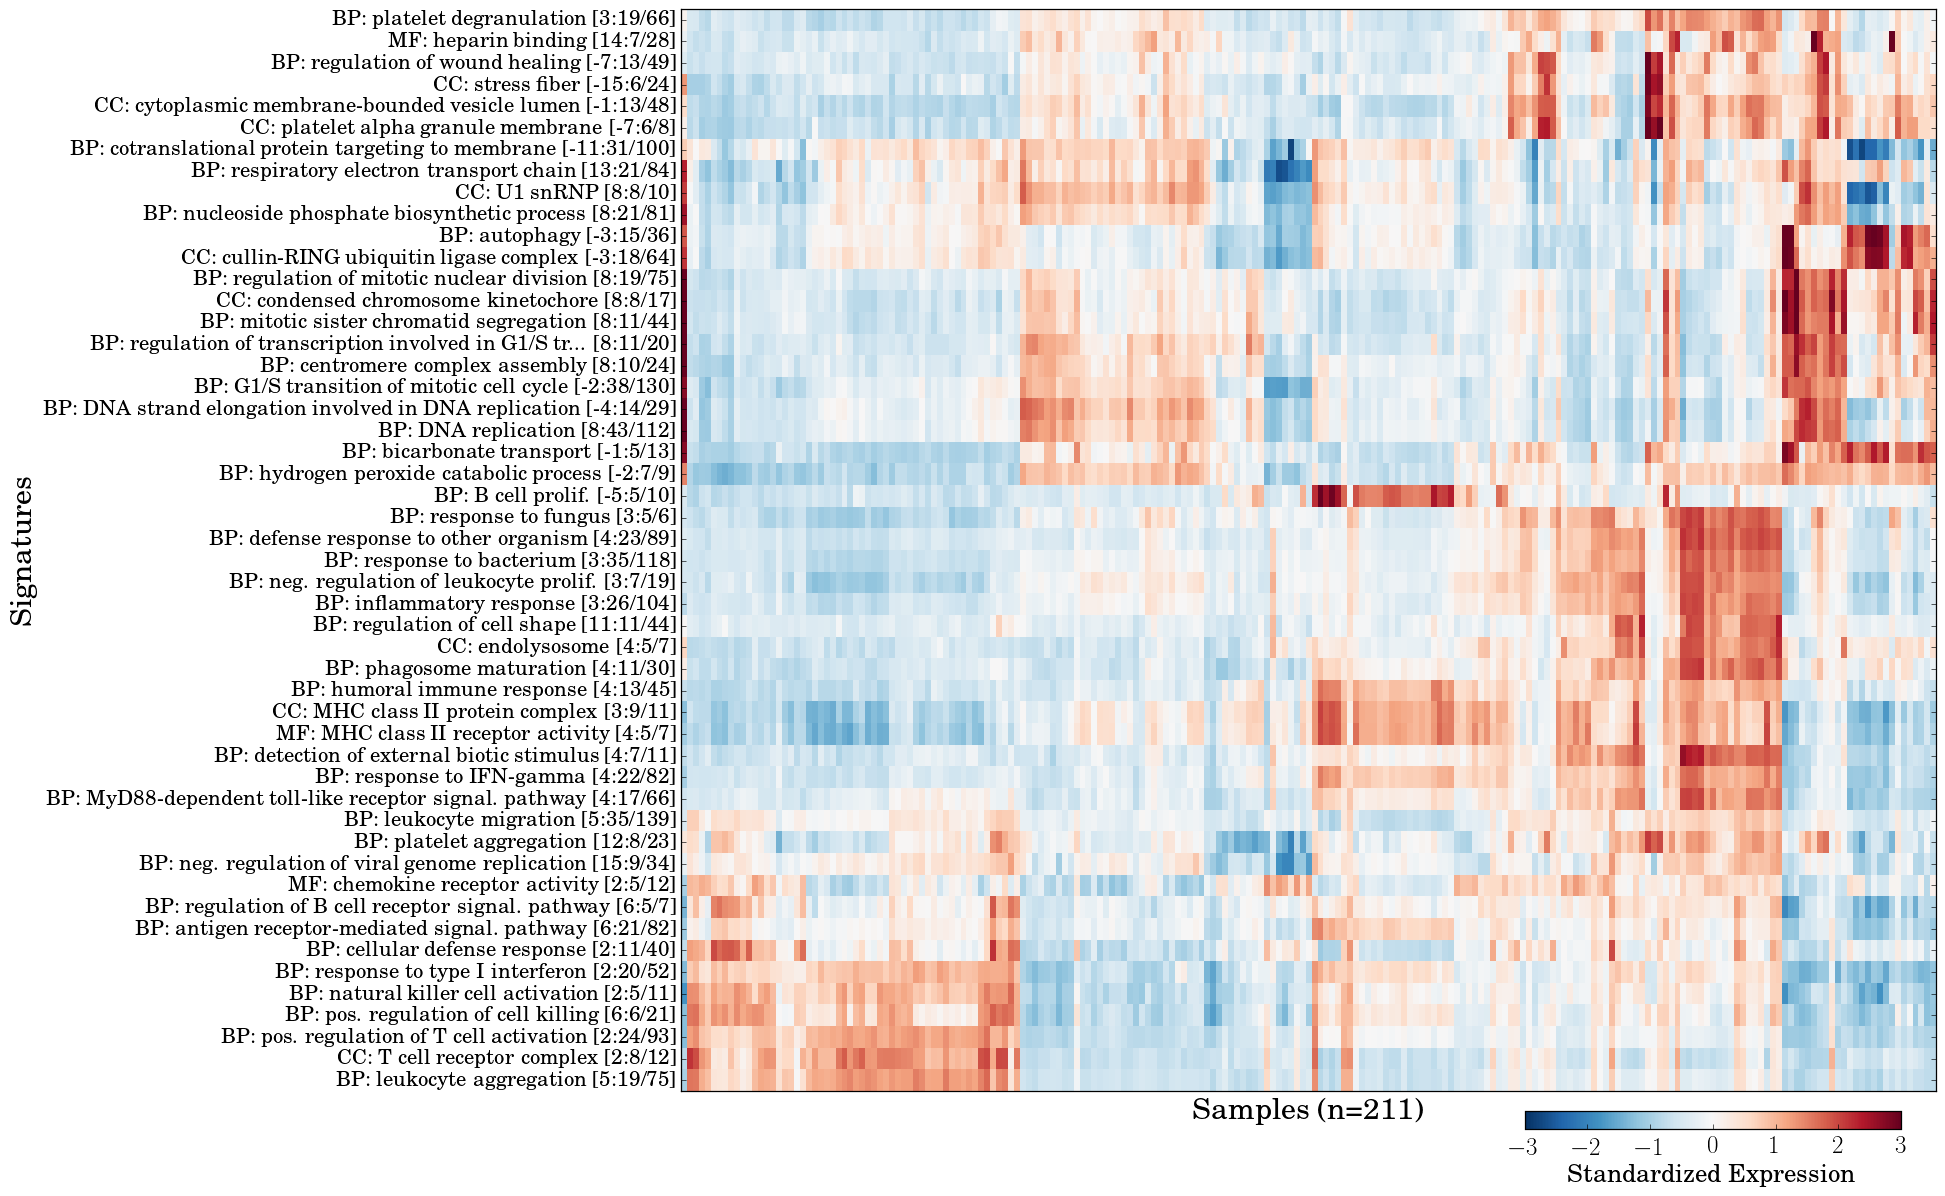

In [10]:
from IPython.display import Image

dpi = 90.0

!gopca_plot_signature_matrix.py -g "$gopca_file" -o "$signature_matrix_image_file" -r $dpi -t 
Image(filename=signature_matrix_image_file,width=800)

[2015-12-10 10:30:22] INFO: Plotting...
[2015-12-10 10:30:22] INFO: Saving to file...
/datapool001/fw36/Dropbox/sandbox/env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
[2015-12-10 10:30:23] INFO: Done!


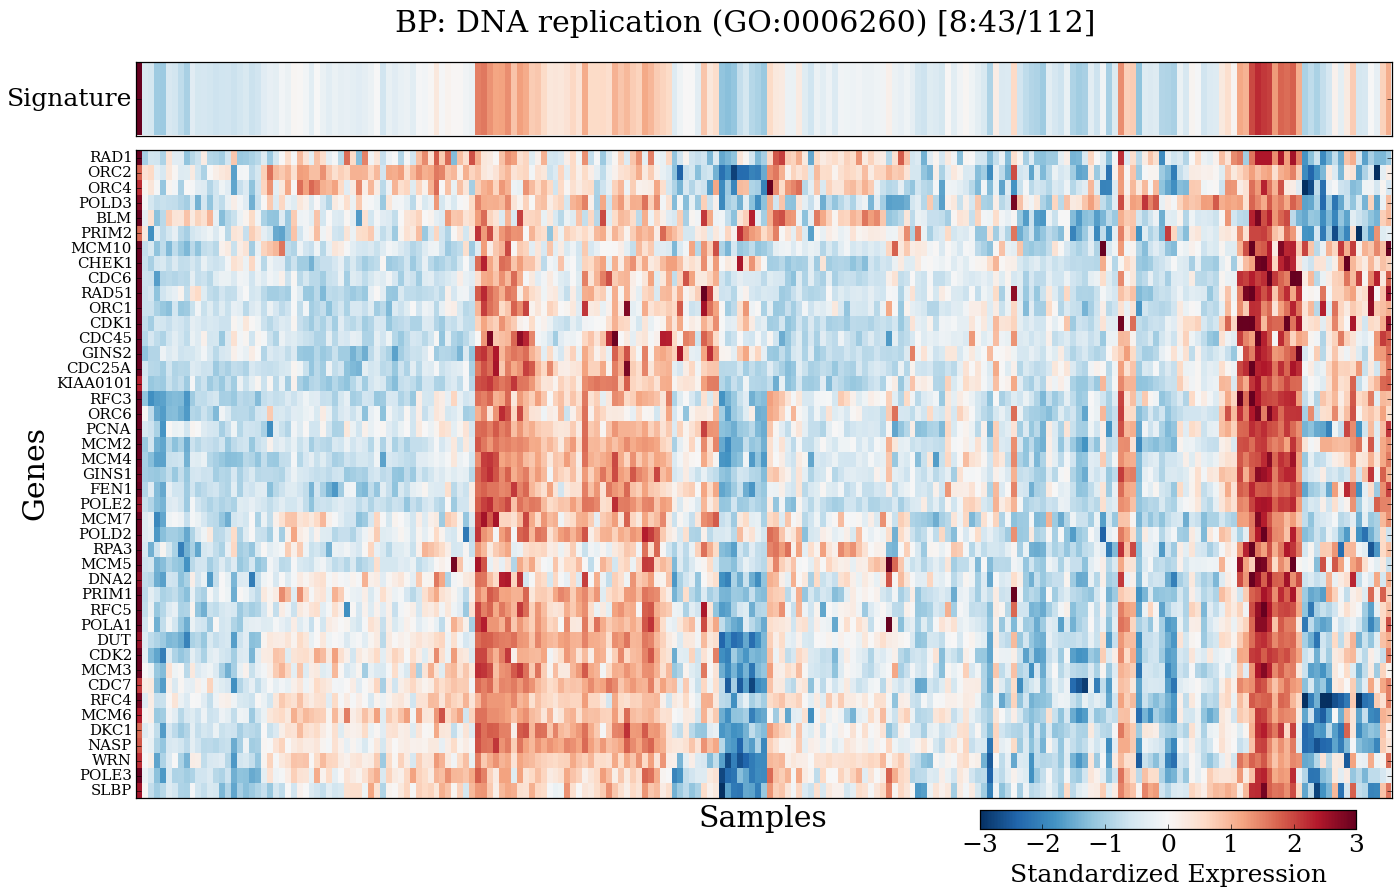

In [11]:
#plot the "DNA replication" signature in detail
from IPython.display import Image

dpi = 90
!gopca_plot_signature.py -g "$gopca_file" -n "DNA replication" -o "$signature_plot_file" -r $dpi -s 18 12 \
        --gene-label-size 12
Image(filename = signature_plot_file, width = 800)

### Save signatures to a tab-delimited file

In [12]:
!gopca_extract_signatures.py -g "$gopca_file" -o "$signature_file"

[2015-12-10 10:30:24] INFO: Wrote 50 signatures to "dmap_signatures.tsv".


### Save signatures to an Excel spreadsheet

In [13]:
!gopca_extract_signatures_excel.py -g "$gopca_file" -o "$signature_excel_file"

[2015-12-10 10:30:25] INFO: Wrote 50 signatures to "dmap_signatures.xlsx".


### Extract the signature matrix

In [14]:
!gopca_extract_signature_matrix.py -g "$gopca_file" -o "$signature_excel_file"

[2015-12-10 10:30:25] INFO: Wrote 50 x 211 expression matrix to "dmap_signatures.xlsx".
[2015-12-10 10:30:25] INFO: Wrote 50 signatures to "dmap_signatures.xlsx".


## Copyright and License

Copyright (c) 2015 Florian Wagner.

This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).